**实验目标：**

通过本实验，你将深入了解和实践说话人识别技术，并掌握利用声音特征进行有效说话人识别的基本方法，了解不同特征和模型对识别准确率的影响。

实验的核心目标是使用TIMIT数据集来训练一个说话人识别系统，涵盖数据预处理、特征提取、模型训练和评估等关键步骤。


**实验方法：**

**1. 数据预处理和划分(可选)：**
  - 数据集下载地址（4月17日前有效）：https://f.ws59.cn/f/du8yd2536vl
  - 为了方便大家，我们提供了划分好的TIMIT数据集结构，当然你也可以根据需求自行划分该数据集。
  - 为简化难度，我们排除了SA的两个方言句子，并在剩余的8个句子中选取了SX的5个句子和SI的1个句子作为训练集，SI的另外2个句子作为测试集。
  - 该链接下载的数据集只保留了音频文件，完整数据集（包含音频对应文本、标注等信息）可参见备注链接下载。
  
**2. 特征提取：**
  - 学习并实现包括但不限于MFCC特征等特征的提取，探索声音信号的频率和时间特性。
  - 鼓励尝试和比较其他特征提取方法，例如LPCC或声谱图特征，以理解不同特征对识别性能的影响。
  
**3. 模型选择和训练：**
  - 探索并选择适合的分类器和模型进行说话人识别，如GMM、Softmax分类器或深度学习模型。
  - 实现模型训练流程，使用训练集数据训练模型。
  
**4. 评估和分析：**
  - 使用准确率作为主要的评价指标在测试集上评估模型性能。
  - 对比不同特征和模型的性能，分析其对说话人识别准确率的影响。
  - 可视化不同模型的识别结果和错误率，讨论可能的改进方法。

**实验要求：**
  - 1.选择并实现至少一种特征的提取，并鼓励尝试其他特征提取方法。
  - 2.选择并实现至少一种分类器或模型进行说话人识别，并使用准确率评估指标评估其性能。
  - 3.通过实验对比、分析和可视化，撰写详细的实验报告，包括实验目的、实验方法、结果分析和结论。
  - 4.实验报告应以清晰、逻辑性强的形式呈现，图表和结果应清楚明了。

**其他说明：**
  - 实验的最终打分环节会看识别性能，会对原理和实现代码部分做抽查提问，综合评定成绩。
  - 我们**鼓励做原创性探索**，即使性能不是很好，但有创新性、有价值、有意义的探索和尝试会有额外加分。
  - 原数完整据集下载地址：https://drive.google.com/file/d/180mSIiXN9RVDV2Xn1xcWNkMRm5J5MjN4/view?usp=sharing \
    或国内访问地址（4月17日前有效）：https://f.ws59.cn/f/du8xu130kba

## 1. 实验准备

In [83]:
## 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import wave
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression

# 可以根据需要导入其他库，比如librosa用于音频处理

## 2. 数据预处理(加载数据集)

In [84]:
## 请从如下地址下载数据集（4月17日前有效）：https://f.ws59.cn/f/du8yd2536vl
# 数据集基本信息如下
# 方言地区：DR1～DR8
# 性别：F/M
# 说话者ID：3大写字母+1阿拉伯数字
# 句子ID：句子类型（SA/SI/SX）+编号
# 详细介绍参见 https://blog.csdn.net/qq_39373179/article/details/103788208

# 上述链接下载的数据集已经
TrainDir = "Dataset\TRAIN"
TestDir = "Dataset\TEST"
# 请在这里写代码加载我们划分好的TIMIT训练集和测试集。或者原始完整版数据集。

def load_data(data_dir):
    data=[] #文件地址
    area_labels=[] #区域
    sex_labels=[] #性别
    labels=[]
    for area_dir in os.listdir(data_dir):
        area_path=os.path.join(data_dir, area_dir) #area_path:Dataset\TRAIN\DR1
        if os.path.isdir(area_path):
            for name_path in os.listdir(area_path): 
                file_path = os.path.join(area_path, name_path) #file_path:Dataset\TRAIN\DR1\FCJF0
                for path_name in os.listdir(file_path):
                    area_labels.append(area_dir)
                    sex_labels.append(name_path[0])
                    path = os.path.join(file_path, path_name)
                    data.append(path)
    labels = [area_label + sex_label for area_label, sex_label in zip(area_labels, sex_labels)]
    return data, labels
    
# 加载训练集和测试集
train_data, train_labels = load_data(TrainDir)
test_data, test_labels = load_data(TestDir)

print("训练集样本数量：", len(train_data))
print("测试集样本数量：", len(test_data))




训练集样本数量： 3234
测试集样本数量： 924


## 3. 特征提取

### 3.1 MFCC音频特征

In [85]:
## 提取MFCC音频特征
def extract_mfcc_features(dataset):
    mfcc_features_list=[]
    for data in dataset:
        # 读取音频文件
        audio, sr = librosa.load(data) #audio:加载的音频数据;sr:音频的采样率
        # 提取MFCC特征
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sr)
        mfcc_features_list.append(mfcc_features)
    return mfcc_features_list

print("训练集数据进行MFCC特征提取...")
train_mfcc = extract_mfcc_features(train_data)
print("训练集MFCC特征:", len(train_mfcc),train_mfcc[0].shape)

print("测试集数据进行MFCC特征提取...")
test_mfcc = extract_mfcc_features(test_data)
print("测试集MFCC特征:", len(test_mfcc),test_mfcc[0].shape)

训练集数据进行MFCC特征提取...
训练集MFCC特征: 3234 (20, 563)
测试集数据进行MFCC特征提取...
测试集MFCC特征: 924 (20, 134)


### mfcc的自主实现

In [ ]:
def mfcc(filename):
    # 读取音频信号
    f = wave.open(filename,'rb')
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    '''
    nchannels: 声道数
    sampwidth: 量化位数
    framerate: 采样频率
    nframes: 采样点数
    '''
    str_data = f.readframes(nframes)
    signal = np.fromstring(str_data, dtype=np.short)
    signal = signal * 1.0 / (max(abs(signal)))# 归一化
    signal_len = len(signal)
    # 预加重
    signal_add = np.append(signal[0], signal[1:] - 0.97 * signal[:-1])
    time = np.arange(0,nframes) / 1.0 * framerate
    # 分帧、加窗
    wlen = 512
    inc = 128
    N = 512
    if signal_len < wlen:
        nf = 1
    else:
        nf = int(np.ceil((1.0 * signal_len - wlen + inc) / inc))
    pad_len = int((nf - 1) * inc + wlen)
    zeros = np.zeros(pad_len - signal_len)
    pad_signal = np.concatenate((signal, zeros))
    indices = np.tile(np.arange(0, wlen), (nf, 1)) + np.tile(np.arange(0, nf * inc, inc),(wlen, 1)).T
    indices = np.array(indices, dtype=np.int32)
    frames = pad_signal[indices]
    win = np.hanning(wlen)

    m = 24
    s = np.zeros((nf, m))
    for i in range(nf):
        x = frames[i:i + 1]
        y = win * x[0]
        a = np.fft.fft(y)# 快速傅里叶变换
        b = np.square(abs(a))# 计算能量谱线
        #  梅尔滤波器
        mel_high = 1125 * np.log(1 + (framerate / 2) / 700)
        mel_point = np.linspace(0, mel_high, m + 2)
        Fp = 700 * (np.exp(mel_point / 1125) - 1)
        w = int(N / 2 + 1)
        df = framerate / N
        fr = []
        for n in range(w):
            frs = int(n * df)
            fr.append(frs)
        melbank = np.zeros((m, w))
        for k in range(m + 1):
            f1 = Fp[k - 1]
            f2 = Fp[k + 1]
            f0 = Fp[k]
            n1 = np.floor(f1 / df)
            n2 = np.floor(f2 / df)
            n0 = np.floor(f0 / df)
            for j in range(w):
                if j >= n1 and j <= n0:
                    melbank[k - 1, j] = (j - n1) / (n0 - n1)
                if j >= n0 and j <= n2:
                    melbank[k - 1, j] = (n2 - j) / (n2 - n0)
            for c in range(w):
                s[i, k - 1] = s[i, k - 1] + b[c:c + 1] * melbank[k - 1, c]
            # plt.plot(fr, melbank[k - 1,])
    # plt.show()
    logs = np.log(s)# 取对数
    num_ceps = 12
    D = dct(logs, type=2, axis=0, norm='ortho')[:, 1:(num_ceps + 1)]
    # print(D)
    # print(filename, np.shape(D))
    return D

### 3.2 声谱图音频特征

In [86]:
#提取声谱图音频特征
def extract_spectrogram_features(dataset):
    spectrogram_features_list = []
    for data in dataset:
        # 读取音频文件
        audio, sr= librosa.load(data)
        # 提取声谱图特征
        spectrogram = np.abs(librosa.stft(y=audio))
        spectrogram_features_list.append(spectrogram)
    return  spectrogram_features_list

train_spectrogram = extract_mfcc_features(train_data)
print("训练集声谱图特征:", len(train_spectrogram), train_spectrogram[0].shape)

test_spectrogram = extract_mfcc_features(test_data)
print("测试集声谱图特征:", len(test_spectrogram), test_spectrogram[0].shape)

训练集声谱图特征: 3234 (20, 563)
测试集声谱图特征: 924 (20, 134)


### 3.3 LPC和LSP

In [87]:
def extract_lpc_lsp_features(dataset, order=12):
    lpc_features_list = []
    lsp_features_list = []
    for data in dataset:
        # 读取音频文件
        audio, sr = librosa.load(data)
        # 提取LPC系数
        lpc = librosa.lpc(audio, order=order)
        lpc_features_list.append(lpc)
        # 提取lsp特征
        lsp = np.roots(lpc)
        lsp_features_list.append(lsp)
    return lpc_features_list,lsp_features_list


train_lpc,train_lsp = extract_lpc_lsp_features(train_data, order=12)
print("训练集LPC特征:", len(train_lpc), train_lpc[0].shape)
print("训练集LSP特征:", len(train_lsp), train_lsp[0].shape)

test_lpc,test_lsp = extract_lpc_lsp_features(test_data, order=12)
print("测试集LPC特征:", len(test_lpc), test_lpc[0].shape)
print("测试集LSP特征:", len(test_lsp), test_lsp[0].shape)



训练集LPC特征: 3234 (13,)
训练集LSP特征: 3234 (12,)
测试集LPC特征: 924 (13,)
测试集LSP特征: 924 (12,)


## 4. 模型选择和训练

### 4.1  mfcc+gmm

In [88]:
#mfcc+gmm
from sklearn.mixture import GaussianMixture

def train_gmm(train_feature, max_length=100, n_components=3):
    # 填充或截断特征
    X_train = []
    for features in train_feature:
        if features.shape[1] < max_length:
            # 填充特征
            padded_features = np.pad(features, ((0, 0), (0, max_length - features.shape[1])), mode='constant')
            X_train.append(padded_features)
        else:
            # 截断特征
            truncated_features = features[:, :max_length]
            X_train.append(truncated_features)

    # 将X_train中的每个特征数组展开为一维数组
    X_train_flattened = np.vstack([feature.ravel() for feature in X_train])

    # 创建并训练GMM分类器
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_train_flattened)

    return gmm

gmm_mfcc = train_gmm(train_mfcc)
gmm_spectrogram=train_gmm(train_spectrogram)




## 5. 评价指标(准确率Accuracy)

In [89]:
#mfcc+gmm
def evaluate_gmm(test, gmm, max_length=100):
    # Preprocess the test data
    X_test = []
    for features in test:
        if features.shape[1] < max_length:
            padded_features = np.pad(features, ((0, 0), (0, max_length - features.shape[1])), mode='constant')
            X_test.append(padded_features)
        else:
            truncated_features = features[:, :max_length]
            X_test.append(truncated_features)

    # Flatten the test data
    X_test_flattened = np.vstack([feature.ravel() for feature in X_test])

    # Predict cluster labels for the test data using the trained GMM classifier
    test_cluster_labels = gmm.predict(X_test_flattened)

    # Calculate the silhouette score for the test data
    silhouette_avg = silhouette_score(X_test_flattened, test_cluster_labels)

    return silhouette_avg

# Example usage
gmm_mfcc_score = evaluate_gmm(test_mfcc, gmm_mfcc )
gmm_spectrogram_score = evaluate_gmm(test_spectrogram, gmm_spectrogram )
print("Silhouette Score:",gmm_mfcc_score)
print("Silhouette Score:",gmm_spectrogram_score)

Silhouette Score: 0.034208763
Silhouette Score: 0.01656629


In [90]:
def adjust_features_length(data, max_length=100):
    adjusted_data = []
    
    for sample in data:
        if sample.shape[1] < max_length:
            padded_sample = np.pad(sample, ((0, 0), (0, max_length - sample.shape[1])), mode='constant')
            adjusted_data.append(padded_sample)
        else:
            truncated_sample = sample[:, :max_length]
            adjusted_data.append(truncated_sample)
    adjusted_data=np.array(adjusted_data)
     # 转置 train_features_adjusted 和 test_features_adjusted
    features = np.transpose(adjusted_data, axes=(0, 2, 1)).reshape(len(adjusted_data), -1)

    return features
# 调整训练数据的特征长度
train_mfcc_adjusted = adjust_features_length(train_mfcc)
# 调整测试数据的特征长度
test_mfcc_adjusted = adjust_features_length(test_mfcc)
softmax_classifier_mfcc = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_classifier_mfcc.fit(train_mfcc_adjusted , train_labels)
predictions_mfcc = softmax_classifier_mfcc.predict(test_mfcc_adjusted)
print(predictions_mfcc)
accuracy_mfcc = accuracy_score(test_labels, predictions_mfcc)

print("准确率：", accuracy_mfcc)
    

['DR4F' 'DR4F' 'DR1F' 'DR1F' 'DR3F' 'DR1F' 'DR4F' 'DR5F' 'DR1F' 'DR4F'
 'DR3F' 'DR8M' 'DR5F' 'DR3F' 'DR5F' 'DR5F' 'DR1F' 'DR2F' 'DR7F' 'DR3F'
 'DR4F' 'DR1F' 'DR7F' 'DR3F' 'DR6F' 'DR7F' 'DR5F' 'DR5F' 'DR4M' 'DR7M'
 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR6M' 'DR7M' 'DR1M' 'DR1M' 'DR1M' 'DR2M'
 'DR1M' 'DR2M' 'DR1M' 'DR2M' 'DR3M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR1M'
 'DR7M' 'DR3M' 'DR5M' 'DR2M' 'DR3M' 'DR3M' 'DR3M' 'DR2M' 'DR4F' 'DR2F'
 'DR4M' 'DR3M' 'DR3M' 'DR2M' 'DR2M' 'DR5M' 'DR8F' 'DR2F' 'DR2M' 'DR1F'
 'DR1M' 'DR5F' 'DR3M' 'DR2M' 'DR2M' 'DR1M' 'DR4M' 'DR4F' 'DR6F' 'DR2F'
 'DR2M' 'DR4F' 'DR2F' 'DR4M' 'DR2F' 'DR5F' 'DR8F' 'DR7F' 'DR4F' 'DR5F'
 'DR4M' 'DR7M' 'DR1F' 'DR2F' 'DR1F' 'DR3F' 'DR7F' 'DR1F' 'DR5F' 'DR3F'
 'DR8F' 'DR7F' 'DR5F' 'DR8F' 'DR5M' 'DR2F' 'DR5F' 'DR2F' 'DR5F' 'DR1F'
 'DR1F' 'DR4M' 'DR6F' 'DR7F' 'DR2F' 'DR4F' 'DR6F' 'DR3F' 'DR8F' 'DR7F'
 'DR1F' 'DR1F' 'DR7M' 'DR7M' 'DR2M' 'DR3M' 'DR5M' 'DR5M' 'DR7M' 'DR7M'
 'DR3M' 'DR2M' 'DR4M' 'DR1M' 'DR1M' 'DR5M' 'DR2M' 'DR6M' 'DR3M' 'DR4M'
 'DR8M

d:\Python\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
# 调整训练数据的特征长度
train_spectrogram_adjusted = adjust_features_length(train_spectrogram)
# 调整测试数据的特征长度
test_spectrogram_adjusted = adjust_features_length(test_spectrogram)
softmax_classifier_spectrogram = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_classifier_spectrogram.fit(train_spectrogram_adjusted , train_labels)
predictions_spectrogram = softmax_classifier_spectrogram.predict(test_spectrogram_adjusted)
print(predictions_spectrogram)
accuracy_spectrogram = accuracy_score(test_labels, predictions_spectrogram)

print("准确率：", accuracy_spectrogram)

['DR4F' 'DR4F' 'DR1F' 'DR1F' 'DR3F' 'DR1F' 'DR4F' 'DR5F' 'DR1F' 'DR4F'
 'DR3F' 'DR8M' 'DR5F' 'DR3F' 'DR5F' 'DR5F' 'DR1F' 'DR2F' 'DR7F' 'DR3F'
 'DR4F' 'DR1F' 'DR7F' 'DR3F' 'DR6F' 'DR7F' 'DR5F' 'DR5F' 'DR4M' 'DR7M'
 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR6M' 'DR7M' 'DR1M' 'DR1M' 'DR1M' 'DR2M'
 'DR1M' 'DR2M' 'DR1M' 'DR2M' 'DR3M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR1M'
 'DR7M' 'DR3M' 'DR5M' 'DR2M' 'DR3M' 'DR3M' 'DR3M' 'DR2M' 'DR4F' 'DR2F'
 'DR4M' 'DR3M' 'DR3M' 'DR2M' 'DR2M' 'DR5M' 'DR8F' 'DR2F' 'DR2M' 'DR1F'
 'DR1M' 'DR5F' 'DR3M' 'DR2M' 'DR2M' 'DR1M' 'DR4M' 'DR4F' 'DR6F' 'DR2F'
 'DR2M' 'DR4F' 'DR2F' 'DR4M' 'DR2F' 'DR5F' 'DR8F' 'DR7F' 'DR4F' 'DR5F'
 'DR4M' 'DR7M' 'DR1F' 'DR2F' 'DR1F' 'DR3F' 'DR7F' 'DR1F' 'DR5F' 'DR3F'
 'DR8F' 'DR7F' 'DR5F' 'DR8F' 'DR5M' 'DR2F' 'DR5F' 'DR2F' 'DR5F' 'DR1F'
 'DR1F' 'DR4M' 'DR6F' 'DR7F' 'DR2F' 'DR4F' 'DR6F' 'DR3F' 'DR8F' 'DR7F'
 'DR1F' 'DR1F' 'DR7M' 'DR7M' 'DR2M' 'DR3M' 'DR5M' 'DR5M' 'DR7M' 'DR7M'
 'DR3M' 'DR2M' 'DR4M' 'DR1M' 'DR1M' 'DR5M' 'DR2M' 'DR6M' 'DR3M' 'DR4M'
 'DR8M

d:\Python\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
softmax_classifier_lpc = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_classifier_lpc .fit(train_lpc, train_labels)
# 使用训练好的模型进行测试数据的预测
predictions_lpc = softmax_classifier_lpc .predict(test_lpc )
print(predictions_lpc)
# 计算准确率并评估模型性能
accuracy_lpc = accuracy_score(test_labels, predictions_lpc)
print("准确率：", accuracy_lpc)



['DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR7M' 'DR7M'
 'DR2M' 'DR7M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR2M' 'DR2M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR2M' 'DR7M'
 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR7M'
 'DR2M' 'DR2M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR2M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR2M'
 'DR2M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR2M'
 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR7M' 'DR2M' 'DR7M' 'DR2M'
 'DR2M' 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR7M' 'DR2M'
 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR2M' 'DR2M' 'DR7M' 'DR2M' 'DR7M' 'DR7M' 'DR2M' 'DR2M' 'DR4M' 'DR7M'
 'DR7M

d:\Python\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
# 将复数特征转换为实数特征
train_lsp_adjusted = np.abs(train_lsp)
test_lsp_adjusted = np.abs(test_lsp)

softmax_classifier_lsp = LogisticRegression(multi_class='multinomial', solver='lbfgs')
softmax_classifier_lsp  .fit(train_lsp_adjusted , train_labels)
# 使用训练好的模型进行测试数据的预测
predictions_lsp = softmax_classifier_lsp .predict(test_lsp_adjusted )
print(predictions_lsp)
# 计算准确率并评估模型性能
accuracy_lsp  = accuracy_score(test_labels, predictions_lsp)
print("准确率：", accuracy_lsp)

d:\Python\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M'
 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M'
 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR5F' 'DR7M' 'DR7M' 'DR4M' 'DR3M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR3M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M'
 'DR3M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR3M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR3M' 'DR7M' 'DR3M' 'DR7M' 'DR7M'
 'DR3M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M' 'DR7M' 'DR3M' 'DR7M' 'DR7M'
 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR7M' 'DR3M'
 'DR3M

##  6. 分析和可视化

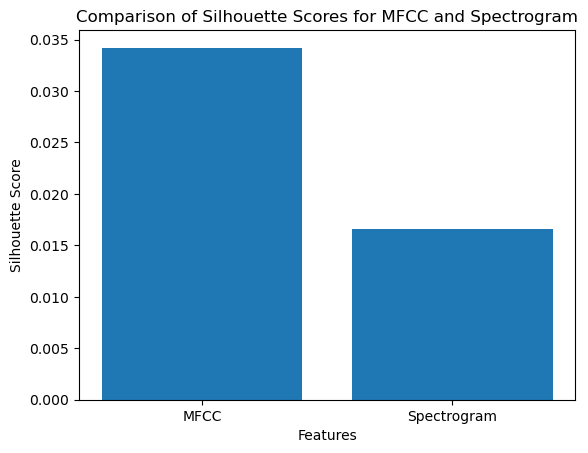

In [97]:
## 请使用matplotlib等可视化库对你的实验结果进行可视化分析。
## 包括但不限于准确率的对比、错误分类的分析、特征的影响等。

# 定义特征和轮廓系数
features = ['MFCC', 'Spectrogram']
scores = [gmm_mfcc_score, gmm_spectrogram_score]

# 绘制柱状图
plt.bar(features, scores)
plt.xlabel('Features')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores for MFCC and Spectrogram')
plt.show()

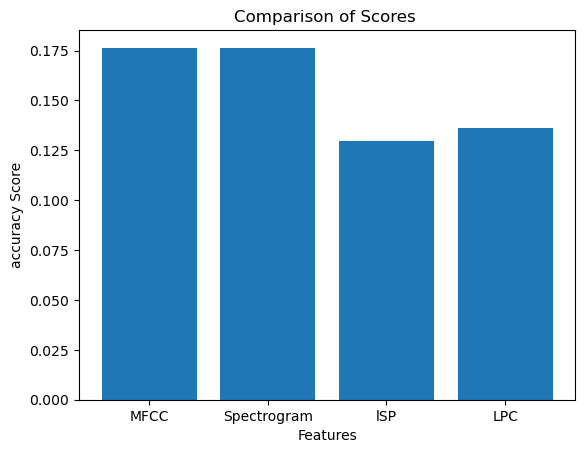

In [98]:
## 请使用matplotlib等可视化库对你的实验结果进行可视化分析。
## 包括但不限于准确率的对比、错误分类的分析、特征的影响等。

# 定义特征和轮廓系数
features = ['MFCC', 'Spectrogram','lSP','LPC']
scores = [accuracy_mfcc, accuracy_spectrogram,accuracy_lsp,accuracy_lpc]

# 绘制柱状图
plt.bar(features, scores)
plt.xlabel('Features')
plt.ylabel('accuracy Score')
plt.title('Comparison of Scores ')
plt.show()

## 7. 结果讨论
讨论你的模型性能，尝试解释为什么某些模型比其他模型表现好，以及可能的改进方法。

## 8. 保存模型（可选）
如果需要，可以在这里添加代码保存你的模型。